# Post competition ML

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn import preprocessing
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

In [2]:
# Prepare the data to test challenge metric
# Define paths
path_to_dataset = './data/'
# Read the training data
train = pd.read_csv(os.path.join(path_to_dataset,'train_data.csv'))
#test = pd.read_csv(os.path.join(path_to_dataset,'test_data.csv'))

In [3]:
# Number of events that has time_to_tca larger and smaller than 2 at the same time
events_less_than_two_days = train[train["time_to_tca"]<1.0].groupby("event_id")["event_id"].first().tolist()
events_more_than_two_days = train[train["time_to_tca"]>2.0].groupby("event_id")["event_id"].first().tolist()
events_trainable = [value for value in events_less_than_two_days if value in events_more_than_two_days]

In [4]:
# Shows an event
train[train['event_id']==events_trainable[2]]

event_id  time_to_tca  mission_id       risk  max_risk_estimate  \
50         4     4.966244          19  -7.870632          -6.800245   
51         4     4.030424          19  -7.968592          -6.807711   
52         4     3.066467          19 -30.000000          -7.661743   
53         4     1.797727          19 -30.000000          -8.792366   
54         4     1.528456          19 -30.000000          -8.795880   
55         4     1.258629          19 -30.000000          -8.763967   
56         4     0.973420          19 -30.000000          -8.759451   
57         4     0.592587          19 -30.000000          -8.764977   
58         4     0.273166          19 -27.650917          -7.819587   

    max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
50          5.111282        31612.0         12093.0                182.4   
51          5.363402        33272.0         12093.0                178.7   
52        434.669432        33593.0         12093.0                163.6   
53       4334.538505        23709.0         12093.0                188.2   
54       4380.345259        23700.0         12093.0                187.7   
55       4022.819178        23099.0         12093.0                182.4   
56       4008.467679        23059.0         12093.0                186.3   
57       4053.221837        23066.0         12093.0                187.1   
58         50.584357        23080.0         12093.0                187.1   

    relative_position_t  ...  t_sigma_rdot  c_sigma_rdot  t_sigma_tdot  \
50             -18561.7  ...      0.315782     23.566497      0.008778   
51             -19540.0  ...      0.216134     22.984521      0.007798   
52             -19727.8  ...      0.081852      2.058484      0.007439   
53             -13921.3  ...      0.049963      1.671888      0.005886   
54             -13915.3  ...      0.038328      1.671888      0.005448   
55             -13563.3  ...      0.038758      1.683556      0.005448   
56             -13540.0  ...      0.037867      1.683555      0.005102   
57             -13545.2  ...      0.023785      1.683555      0.004298   
58             -13552.1  ...      0.024574      4.373659      0.004242   

    c_sigma_tdot  t_sigma_ndot  c_sigma_ndot   F10   F3M   SSN    AP  
50      0.062139      0.005695      0.078138  87.0  86.0  29.0  20.0  
51      0.061950      0.005318      0.078065  85.0  86.0  26.0  35.0  
52      0.054042      0.005327      0.076470  84.0  86.0  30.0  36.0  
53      0.331101      0.005107      0.303638  82.0  86.0  17.0  36.0  
54      0.331101      0.005037      0.303638  82.0  86.0  17.0  36.0  
55      0.331079      0.005038      0.303620  80.0  86.0  12.0  20.0  
56      0.331080      0.007247      0.303619  80.0  86.0  12.0  20.0  
57      0.331080      0.006655      0.303619  80.0  86.0  12.0  20.0  
58      0.331474      0.006524      0.303632  81.0  86.0   0.0  17.0  

[9 rows x 103 columns]

In [5]:
# Generates new training data that uses last available CDM (until 2 days to tca) and \
# adds latest CDM risk as target variable
lenData = len(events_trainable)
new_train = []
target_variable = []
for cnt in range(lenData):
    new_train.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)][-1:].values.tolist()[0])
    target_variable.append(train[(train["event_id"]==events_trainable[cnt])][-1:].risk.values[0])
df = pd.DataFrame(new_train,columns=train.columns.tolist())
# Adds target value to the dataset
target_variable_pd = pd.DataFrame(target_variable,columns=["target_risk"])
df["target_risk"] = target_variable_pd.values

In [6]:
# clipping at a risk of -6.001
df.loc[df['target_risk']<-6,'target_risk']=-6.001
df.loc[df['risk']<-6,'risk']=-6.001

### the model’s target was defined to be the change in risk value between the input CDM and the event’s final CDM

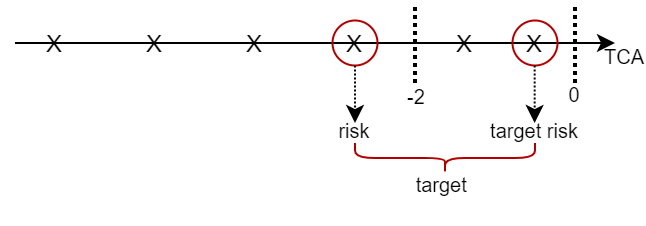

### it allows for a direct comparison to the LRP baseline as the model predicts a new estimator h such that r = LRP + h.

In [7]:
# target 
df['target'] = df['target_risk'] - df['risk']

In [8]:
df['risk_class'] = 0
df['risk_class'].where(df['target_risk']>=-6, 1, inplace=True)

In [9]:
df

event_id  time_to_tca  mission_id      risk  max_risk_estimate  \
0            2     2.340627           2 -6.001000          -6.266241   
1            3     2.278941          19 -6.001000          -7.320481   
2            4     3.066467          19 -6.001000          -7.661743   
3            5     2.103772           5 -6.001000          -4.878440   
4            6     2.040187           1 -6.001000          -5.079355   
...        ...          ...         ...       ...                ...   
8288     13146     4.706555           3 -5.105407          -5.048614   
8289     13147     2.120492           7 -6.001000          -6.113961   
8290     13148     2.014028           7 -6.001000          -5.223081   
8291     13150     6.322295           9 -6.001000          -7.004628   
8292     13152     2.128300          15 -6.001000          -7.103143   

      max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
0           401.442549        18763.0         14347.0               -692.9   
1           140.001151        23900.0         13574.0                 26.3   
2           434.669432        33593.0         12093.0                163.6   
3            23.068536          304.0          2001.0                -13.8   
4           554.289715        10864.0         10027.0                139.5   
...                ...            ...             ...                  ...   
8288          0.566787         1056.0         14781.0               -222.8   
8289          8.648661        18980.0         13296.0                -65.7   
8290        210.247272         3914.0         10330.0               -172.4   
8291       7361.969599         3569.0         14952.0              -1717.6   
8292       1416.589071        24921.0          1156.0              -1158.1   

      relative_position_t  ...  c_sigma_tdot  t_sigma_ndot  c_sigma_ndot  \
0                 -5175.6  ...      0.053199      0.003115      0.194275   
1                 10072.2  ...      0.056902      0.007782      0.160887   
2                -19727.8  ...      0.054042      0.005327      0.076470   
3                  -301.3  ...      0.005165      0.004303      0.004416   
4                 -8143.1  ...      0.016114      0.004511      0.018473   
...                   ...  ...           ...           ...           ...   
8288                127.5  ...      0.316949      0.002212      0.539461   
8289               9261.2  ...      0.204299      0.004043      0.149835   
8290               2872.2  ...      0.005466      0.003766      0.007914   
8291               -345.9  ...      0.070820      0.002989      0.027618   
8292             -24852.2  ...      0.041585      0.001586      0.102717   

       F10   F3M   SSN    AP  target_risk    target  risk_class  
0     69.0  77.0  11.0   6.0       -6.001  0.000000           1  
1     68.0  70.0   0.0   7.0       -6.001  0.000000           1  
2     84.0  86.0  30.0  36.0       -6.001  0.000000           1  
3     70.0  77.0  11.0   5.0       -6.001  0.000000           1  
4     72.0  70.0  14.0   4.0       -6.001  0.000000           1  
...    ...   ...   ...   ...          ...       ...         ...  
8288  67.0  72.0   0.0   5.0       -6.001 -0.895593           1  
8289  73.0  77.0  31.0   4.0       -6.001  0.000000           1  
8290  69.0  71.0  12.0   6.0       -6.001  0.000000           1  
8291  69.0  69.0   0.0   5.0       -6.001  0.000000           1  
8292  71.0  72.0  15.0   4.0       -6.001  0.000000           1  

[8293 rows x 106 columns]

In [10]:
# Data split
X = df.drop(columns=[
    'mission_id',
    'c_object_type',
    #'risk',
    'target_risk',
    #'target'
])
y = df['risk_class'].copy()

In [12]:
X

event_id  time_to_tca      risk  max_risk_estimate  max_risk_scaling  \
0            2     2.340627 -6.001000          -6.266241        401.442549   
1            3     2.278941 -6.001000          -7.320481        140.001151   
2            4     3.066467 -6.001000          -7.661743        434.669432   
3            5     2.103772 -6.001000          -4.878440         23.068536   
4            6     2.040187 -6.001000          -5.079355        554.289715   
...        ...          ...       ...                ...               ...   
8288     13146     4.706555 -5.105407          -5.048614          0.566787   
8289     13147     2.120492 -6.001000          -6.113961          8.648661   
8290     13148     2.014028 -6.001000          -5.223081        210.247272   
8291     13150     6.322295 -6.001000          -7.004628       7361.969599   
8292     13152     2.128300 -6.001000          -7.103143       1416.589071   

      miss_distance  relative_speed  relative_position_r  relative_position_t  \
0           18763.0         14347.0               -692.9              -5175.6   
1           23900.0         13574.0                 26.3              10072.2   
2           33593.0         12093.0                163.6             -19727.8   
3             304.0          2001.0                -13.8               -301.3   
4           10864.0         10027.0                139.5              -8143.1   
...             ...             ...                  ...                  ...   
8288         1056.0         14781.0               -222.8                127.5   
8289        18980.0         13296.0                -65.7               9261.2   
8290         3914.0         10330.0               -172.4               2872.2   
8291         3569.0         14952.0              -1717.6               -345.9   
8292        24921.0          1156.0              -1158.1             -24852.2   

      relative_position_n  ...  t_sigma_tdot  c_sigma_tdot  t_sigma_ndot  \
0                 18022.2  ...      0.004753      0.053199      0.003115   
1                 21674.9  ...      0.008990      0.056902      0.007782   
2                 27190.5  ...      0.007439      0.054042      0.005327   
3                   -41.3  ...      0.005818      0.005165      0.004303   
4                 -7190.7  ...      0.001345      0.016114      0.004511   
...                   ...  ...           ...           ...           ...   
8288              -1024.8  ...      0.003196      0.316949      0.002212   
8289              16567.2  ...      0.005571      0.204299      0.004043   
8290              -2653.5  ...      0.006259      0.005466      0.003766   
8291               3110.0  ...      0.001430      0.070820      0.002989   
8292               1450.3  ...      0.001393      0.041585      0.001586   

      c_sigma_ndot   F10   F3M   SSN    AP    target  risk_class  
0         0.194275  69.0  77.0  11.0   6.0  0.000000           1  
1         0.160887  68.0  70.0   0.0   7.0  0.000000           1  
2         0.076470  84.0  86.0  30.0  36.0  0.000000           1  
3         0.004416  70.0  77.0  11.0   5.0  0.000000           1  
4         0.018473  72.0  70.0  14.0   4.0  0.000000           1  
...            ...   ...   ...   ...   ...       ...         ...  
8288      0.539461  67.0  72.0   0.0   5.0 -0.895593           1  
8289      0.149835  73.0  77.0  31.0   4.0  0.000000           1  
8290      0.007914  69.0  71.0  12.0   6.0  0.000000           1  
8291      0.027618  69.0  69.0   0.0   5.0  0.000000           1  
8292      0.102717  71.0  72.0  15.0   4.0  0.000000           1  

[8293 rows x 103 columns]

In [13]:
y

0       1
1       1
2       1
3       1
4       1
       ..
8288    1
8289    1
8290    1
8291    1
8292    1
Name: risk_class, Length: 8293, dtype: int64

In [11]:
# Metrics
def y_clf(y):
    yclf = (y>=-6).astype(int)
    return yclf
                        
def msehr(y_true, y_pred):
    ytrue_clf = y_clf(y_true)
    n_star = np.sum(ytrue_clf)
    mse = (1/n_star)*np.sum(ytrue_clf*(np.power(y_true-y_pred,2)))
    return mse

def f2(y_true, y_pred):
    ytrue_clf = y_clf(y_true)
    ypred_clf = y_clf(y_pred)
    return fbeta_score(ytrue_clf, ypred_clf, beta=2)

def L(y_true, y_pred):
    f_2 = f2(y_true, y_pred)
    mse = msehr(y_true, y_pred)
    return 1/f_2*mse

In [12]:
kf = KFold(n_splits=3, random_state=1)
for kk , (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
    X_train, y_test = shuffle(X_train, y_train)

    risk_train = X_train['risk']
    risk_test = X_test['risk']
    y_train = X_train['target']
    y_test = X_test['target']
    X_train.drop(columns=['risk','target'], inplace=True)
    X_test.drop(columns=['risk','target'], inplace=True)
    
    
    #h (target) was encoded through a quantile transformer to assume a uniform distribution
    qt = preprocessing.QuantileTransformer(n_quantiles=X_train.shape[0], random_state=0)
    y_train = qt.fit_transform(y_train.values.reshape(-1, 1))
    #y_test = qt.transform(y_test.values.reshape(-1, 1))
    
    #LGBMRegressor
    model = lightgbm.LGBMRegressor(
        learning_rate=0.05,
        n_estimators=25,
        feature_fraction=0.25
    )
    
    model.fit(X_train, y_train.ravel())
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    y_train = qt.inverse_transform(y_train.reshape(-1, 1))
    y_pred_train = qt.inverse_transform(y_pred_train.reshape(-1, 1))
    y_pred_test = qt.inverse_transform(y_pred_test.reshape(-1, 1))
    
    print('------------ %2d ------------' % (kk+1))
    #plt.plot(y_test.ravel()+risk_test.values, y_pred.ravel()+risk_test.values, '.')
    #plt.plot(y_test.ravel(), y_pred.ravel(), '.')
    
    # Baseline
    #LRP = np.where(risk_test.values>=-6, risk_test.values, -6.001)
    #print(1/f2(y_test[:,0]+risk_test.values, LRP))
    #print(msehr(y_test[:,0]+risk_test.values, LRP))
    #print(L(y_test[:,0]+risk_test.values, LRP))

    
    # 1/F2 Score
    f2_score_train = 1/f2(y_train.ravel()+risk_train.values, y_pred_train.ravel()+risk_train.values)
    f2_score_test = 1/f2(y_test.ravel()+risk_test.values, y_pred_test.ravel()+risk_test.values)
    
    # Mean Squared Error
    mse_train = msehr(y_train.ravel()+risk_train.values, y_pred_train.ravel()+risk_train.values)
    mse_test = msehr(y_test.ravel()+risk_test.values, y_pred_test.ravel()+risk_test.values)
    
    # Final Score/Loss
    loss_train = L(y_train.ravel()+risk_train.values, y_pred_train.ravel()+risk_train.values)
    loss_test = L(y_test.ravel()+risk_test.values, y_pred_test.ravel()+risk_test.values)    
    
    print('{:<10}{:<10}{:<10}{:<10}'.format('','1/F2','MSE','Loss'))
    print('{:<10}{:<10.5}{:<10.5}{:<10.5}'.format('Train',f2_score_train, mse_train, loss_train))
    print('{:<10}{:<10.5}{:<10.5}{:<10.5}'.format('Test',f2_score_test, mse_test, loss_test))
    

/home/rabay/anaconda3/envs/collision_ESA/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/rabay/anaconda3/envs/collision_ESA/lib/python3.6/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
------------  1 ------------
          1/F2      MSE       Loss      
Train     2.1568    0.3137    0.67658   
Test      3.46      0.36819   1.2739    
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
------------  2 ------------
          1/F2      MSE       Loss      
Train     2.8214    0.379     1.0693    
Test      1.8632    0.23264   0.43345   


/home/rabay/anaconda3/envs/collision_ESA/lib/python3.6/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/rabay/anaconda3/envs/collision_ESA/lib/python3.6/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
------------  3 ------------
          1/F2      MSE       Loss      
Train     2.4138    0.29719   0.71735   
Test      2.4667    0.38801   0.95709   
